# DL in NLP

## Task 2: Classifying TED talks

Sergei Volodin, senior undergraduate student at MIPT

In [1]:
%matplotlib inline
import tensorflow as tf
import json
import numpy as np
import pandas as pd
import collections
from __future__ import print_function
import re
import random
import math
from sklearn.manifold import TSNE
from matplotlib import pylab
from transliterate import translit
from six.moves import range
import sklearn.metrics
import matplotlib.pyplot as plt
from six.moves import cPickle as pickle
from tqdm import tqdm

In [2]:
def print_unicode(ent):
    print(repr(ent).decode("unicode-escape"))

In [3]:
filename = 'ted_ru-20160408.json'
data_test = json.loads(open(filename + '.test', 'r').read(), 'unicode-escape')
data_train = json.loads(open(filename + '.train', 'r').read(), 'unicode-escape')

Plan:

1. Removing non-letters
2. Obtaining words, training word2vec CBOW model
3. Running RNN on document
4. Classifying based on final hidden state

# Building dictionary

In [16]:
vocabulary_size = 100000
embedding_size = 256
context_size = 4
words_regex = re.compile(ur'[^а-яА-ЯёЁa-zA-Z]')

def str_to_words(s):
    return(words_regex.sub(' ', s).lower().split())

def data_to_str(data):
    return(' '.join(map(lambda x : x['content'], data_train)))

def build_dataset(words, vocabulary_size):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0
            unk_count = unk_count + 1
        data.append(index)
    count[0][1] = unk_count
    return data, count, dictionary

In [8]:
all_text = data_to_str(data_train)# + data_to_str(data_test)
words = str_to_words(all_text)
data, count, dictionary = build_dataset(words, vocabulary_size)

In [6]:
print_unicode(count[:5])
print_unicode(data[:10])

[['UNK', 101368], (u'и', 184180), (u'в', 167020), (u'что', 114608), (u'я', 94278)]
[4, 50, 42336, 12867, 7687, 21, 4462, 741, 106, 31183]


# Pretraining CBOW word2vec embeddings

In [26]:
data_index = 0

def to_range(n):
    return(n % len(data))

# CBOW model
def generate_batch(batch_size, context_size):
    global data_index
  
    data_index = to_range(data_index)
    
    batch = np.ndarray(shape=(batch_size, context_size * 2), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    for i in range(batch_size):
        labels[i] = data[data_index]
        for j in range(0, context_size):
            batch[i][2 * j] = data[to_range(data_index - (j + 1))]
            batch[i][2 * j + 1] = data[to_range(data_index + (j + 1))]
        data_index = to_range(data_index + 1)
        
    return batch, labels

In [27]:
batch_size = 128
num_sampled = 256
graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size, context_size * 2], name = "train_dataset")
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1], name = "train_labels")
  
    # Variables.
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0), name = "embeddings")
    softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)), name = "SM_weights")
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]), name = "SM_biases")
    
    embed = tf.reduce_mean(tf.nn.embedding_lookup(embeddings, train_dataset), [1], name = "emb_result")
    loss = tf.reduce_mean(
      tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size), name = "loss")

  
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
    
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    
    tf.summary.scalar("Embedding_loss", loss)
    summary_emb = tf.summary.merge_all()

In [28]:
logs_path = '~/tensorboard/01'
writer = tf.summary.FileWriter(logs_path, graph=graph)

In [29]:
epochs = 30000
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    for epoch in tqdm(range(epochs)):
        batch_data, batch_labels = generate_batch(batch_size, context_size)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l, summary = session.run([optimizer, loss, summary_emb], feed_dict = feed_dict)
        writer.add_summary(summary, epoch)
    final_embeddings = normalized_embeddings.eval()

100%|██████████| 30000/30000 [10:37<00:00, 47.08it/s]


In [49]:
emb_fn = "emb.pkl"
pickle.dump(final_embeddings, open(emb_fn, 'w'))
#final_embeddings = pickle.load(open(emb_fn, 'r'))

# Preparing dataset

In [143]:
pad_word = vocabulary_size
max_words = 5600
num_classes = 8

In [138]:
def str_to_idx(s):
    words = str_to_words(s)
    res = []
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0
        res.append(index)
    return(res)
def get_Y(data):
    classes = map(lambda x: x['class'] - 1, data_train)
    return(np.array(classes))
def get_X(data):
    X = map(lambda x : str_to_idx(x['content']), data)
    X = map(lambda x : x + [pad_word] * (max_words - len(x)), X)
    return np.array(X), np.array(L)

In [ ]:
X, L = get_X(data_train)

In [139]:
Y = get_Y(data_train)

In [ ]:
Xtest, Ltest = get_X(data_test)

# Word length distributions

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa4abfbbfd0>]], dtype=object)

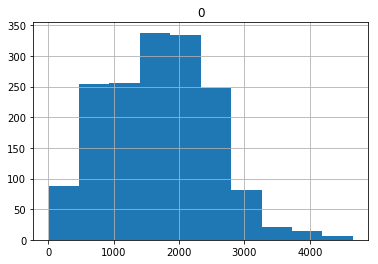

In [69]:
pd.DataFrame(L).hist()
plt.title('Train set length')

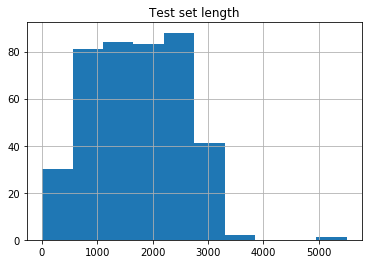

In [75]:
pd.DataFrame(Ltest).hist()
plt.title('Test set length')

# RNN classifier

# TF

In [ ]:
sess.close()
sess = tf.InteractiveSession()

In [ ]:
c_graph = tf.Graph()
with c_graph.as_default():
    text_input = tf.placeholder(tf.int32, shape=[None, None])
    text_length = tf.placeholder(tf.float32, shape=[None])
    ans_input = tf.placeholder(tf.float32, shape=[None])
    
    emb_words   = tf.Variable(final_embeddings, name = "embeddings", trainable = False, dtype = tf.float32)
    emb_padding = tf.Variable(1. * np.zeros((1, embedding_size)), trainable = False, dtype = tf.float32)
    embeddings = tf.concat([emb_words, emb_padding], 0)
    
    word_vectors = tf.reshape(tf.nn.embedding_lookup(embeddings, text_input), [-1, max_words, embedding_size])
    
    # Split into list of embedding per word, while removing doc length
    # dim. word_list results to be a list of tensors [batch_size, 
    # EMBEDDING_SIZE].  
    word_list = tf.unstack(word_vectors, axis=1)
    # Create a Gated Recurrent Unit cell with hidden size of EMBEDDING_SIZE.
    cell = tf.contrib.rnn.LSTMCell(embedding_size)
    # Create an unrolled Recurrent Neural Networks to length of  
    # MAX_DOCUMENT_LENGTH and passes word_list as inputs for each 
    # unit.
    _, encoding = tf.contrib.rnn.static_rnn(cell, word_list, sequence_length = text_length, dtype = tf.float32)
    # Given encoding of RNN, take encoding of last step (e.g hidden 
    # size of the neural network of last step) and pass it as features 
    # to fully connected layer to output probabilities per class.  
    target = tf.one_hot(ans_input, num_classes)
    logits = tf.contrib.layers.fully_connected(encoding, num_classes, activation_fn=None)  
    loss = tf.contrib.losses.softmax_cross_entropy(logits, target)
    
    train_op = tf.contrib.layers.optimize_loss(
        loss, tf.contrib.framework.get_global_step(),
        optimizer='Adam', learning_rate=0.01, clip_gradients=1.0)
    
    answer = tf.argmax(logits, 1)
    probability = tf.nn.softmax(logits)

In [156]:
tf.contrib.rnn.rnn

AttributeError: 'module' object has no attribute 'rnn'

In [130]:
sess = tf.InteractiveSession()